November: Part 3 - This notebook is a continuation of gyre_runs.ipynb and gyre_runs_mackenzie01.ipynb. The configuration used to produce these results is gyre_mackenzie02. Parameters explored: ln_tsd_init, ln_tsd_tradmp, sn_tem, sn_sal.

Changes since Part 2:
* matlab scaling factors script has transposed lons and lats so it won't flip the dimensions
* masking land using [Nancy notebook](http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/analysis-nancy/raw/tip/notebooks/Masking%20with%20tmask.ipynb)
* now, we have the realistic bathymetry that matches the idealized bathymetry
* the idealized bathymetry has been refined (slope)
* the stratification based on Arctic data is inputted into the model

In [3]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/modules/')
import functions_plot

from salishsea_tools import nc_tools

In [37]:
def plot_gyre_times(gridT, var, depth_ind, time_inds, cmax, cmaps, max_min, supttl):
    cmin = -cmax
    cmaps.set_bad('wheat')
    fig, ax = plt.subplots(1, len(time_inds), figsize=(20, 4.5), sharex=True, sharey=True)
    for i, n in zip(time_inds, np.arange(len(time_inds))):
        if max_min == True:
            c = ax[n].pcolormesh(var[i,depth_ind,:,:], cmap=cmaps, vmin = cmin, vmax = cmax)
            if n == 0:
                cbar = fig.colorbar(c, ax=ax[0])
        elif max_min == False:
            c = ax[n].pcolormesh(var[i,depth_ind,:,:], cmap=cmaps)
            cbar = fig.colorbar(c, ax=ax[n])
        timestamp = nc_tools.timestamp(gridT,i).format('HH:mm')
        ax[n].set_title('time: ' + timestamp, fontsize=16)
        ax[n].set_xlim(0,gridT.dimensions['x'].size)
        ax[n].set_ylim(0,gridT.dimensions['y'].size)
        ax[n].xaxis.set_visible(False); ax[n].yaxis.set_visible(False)
    title = supttl + ' (' + str(int(gridT['deptht'][depth_ind])) + 'm)'
    fig.tight_layout(); fig.subplots_adjust(top=0.85); fig.suptitle(title, fontsize=20)
    return fig

def plot_vars(gridT, all_vars, depth_ind, time_ind, cmaxs, cmaps, max_min, supttl, ttls):
    cmins = [-x for x in cmaxs]
    cmaps.set_bad('wheat')
    fig, ax = plt.subplots(1, len(all_vars), figsize=(20, 4.5), sharex=True, sharey=True)
    for var, cmin, cmax, n, ttl in zip(all_vars, cmins, cmaxs, np.arange(len(all_vars)), ttls):
        if max_min == True:
            c = ax[n].pcolormesh(var[time_ind,depth_ind,:,:], cmap=cmaps, vmin = cmin, vmax = cmax)
            cbar = fig.colorbar(c, ax=ax[n])
        elif max_min == False:
            c = ax[n].pcolormesh(var[time_ind,depth_ind,:,:], cmap=cmaps)
            cbar = fig.colorbar(c, ax=ax[n])
        timestamp = nc_tools.timestamp(gridT,time_ind).format('HH:mm')
        #ax[n].set_xlim(0,gridT.dimensions['x'].size)
        #ax[n].set_ylim(0,gridT.dimensions['y'].size)
        ax[n].xaxis.set_visible(False); ax[n].yaxis.set_visible(False)
        ax[n].set_title(ttl, fontsize=16)
    title = supttl + ' (' + str(int(gridT['deptht'][depth_ind])) + 'm, ' + timestamp + ')'
    fig.tight_layout(); fig.subplots_adjust(top=0.85); fig.suptitle(title, fontsize=20)
    return fig

## Summary


* cp_cfg name
* bathy_meter.nc and coordinates.nc
* nn_bathy = 1 (0 for compute)
* jphgr_msh = 0 (5 for gyre)
* jperio = 1 (cyclic)
* ln_zco, ln_zps
* jpidta = jpiglo, jpjdta = jpjglo, jpkdta 


|Parameter      |Run01 (Id)|Run01 (Re)|
|---------------|----------|----------|
|cp_cfg         |ideal     |real      |
|ln_bt_nn_auto  |False     |True      |
|rn_bt_cmax     |NA        |0.05      |
|rn_rdt         |20        |10        |
|nn_baro        |4         |NA        |
|calc nn_baro   |NA        |5         |
|nn_itend       |2160 (12h)|4320 (12h)|
|nn_write       |360 (1h)  |---       |
|nn_tau000 [ts] |540 (3h)  |1080      |
|rn_utau0 [N/m2]|-5.0      |-5.0      |
|rn_vtau0 [N/m2]|0         |0         |
|status         | ✓(2160)  | ✓ (4320) |

* under these nn_itend and nn_write, the stages where the code can fail are [1, 361, 721, 1081, 1441, 1801]
* from Part 2, remember you have to reduce timestep and then consider the wind forcing

In [5]:
# calculate nn_baro using rn_rdt and cmax
g = 9.81; cmax = 0.05; dx = 4501; H = 1300; dt_clinic = 10 #(rn_rdt)
u = np.sqrt(g * H)
dt_tropic = (cmax * dx) / u
iterations = dt_clinic / dt_tropic
iterations

5.0179596244528888

# Run01: Idealized vs Realistic

These runs use a configuration similar to the ones that are proven to run from gyre_runs_mackenzie01.ipynb. Both runs try to simulate the same scenario. The realistic needed a smaller timestep so nn_itend and nn_tau were modified to accommodate this change. The original gyre stratification was used.

1. mackenzie_canyon/bathymetry/initial_sets/idealized/**ideal_bathy_01.nc**
2. mackenzie_canyon/bathymetry/initial_sets/realistic/**real_bathy_01.nc**
3. mackenzie_canyon/bathymetry/initial_sets/coordinates/**coords_01.nc**

In [6]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run01'
gridT_I1, lon_I1, lat_I1, tem_I1, sal_I1, ssh_I1, U_I1, V_I1, W_I1 = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_realistic/Run01'
gridT_R1, lon_R1, lat_R1, tem_R1, sal_R1, ssh_R1, U_R1, V_R1, W_R1 = functions_plot.load_model_output(path, cfg)

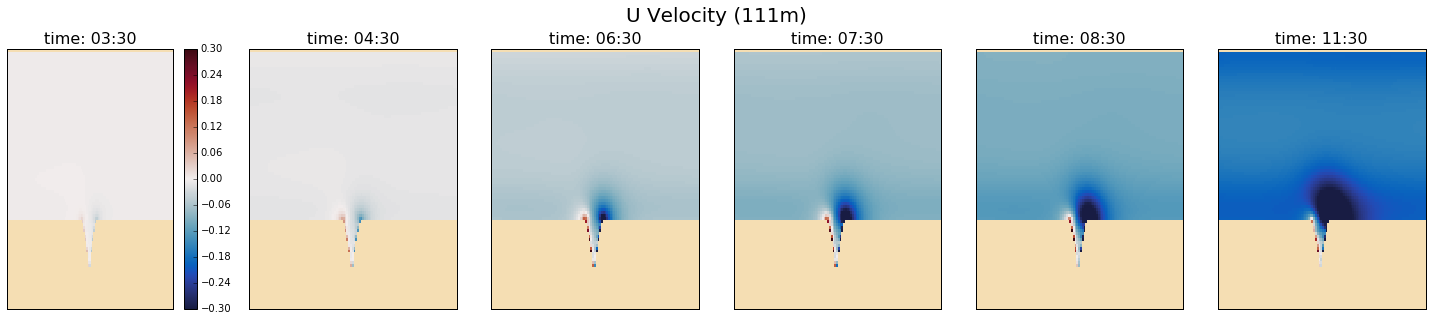

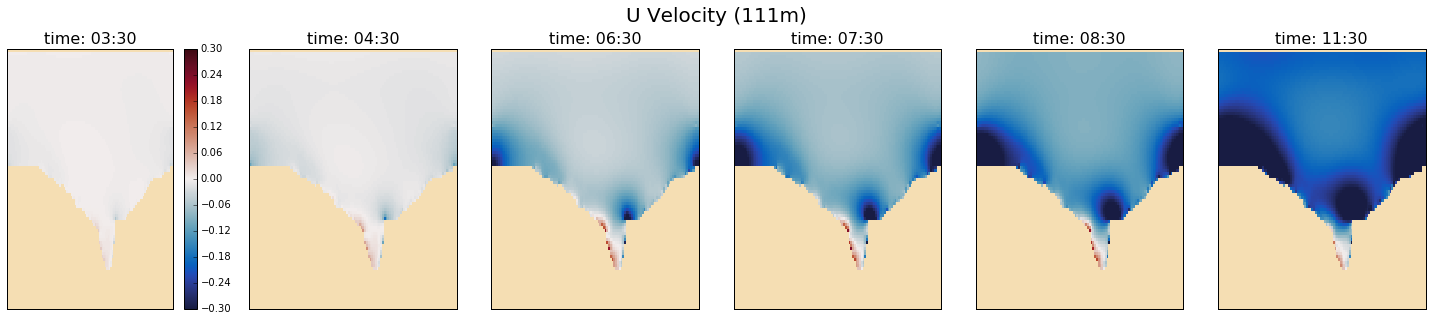

In [7]:
dep = 8
time_inds = [3,4,6,7,8,11]
bd = 0.3
max_min = True
supttl = 'U Velocity'
fig = plot_gyre_times(gridT_I1, U_I1, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)
fig = plot_gyre_times(gridT_R1, U_R1, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)

# Run02: Arctic Stratification

These runs have the **same configurations** as Run01 and still use **ideal_bathy_01.nc**, **real_bathy_01.nc**, and **coords_01.nc**. What's new is that these runs use the temperature and salinity files created in prepare_stratification.ipynb.

1. mackenzie_canyon/conditions/stratification_files/**temp_strat.nc** & **temp_strat_real.nc**
2. mackenzie_canyon/conditions/stratification_files/**salt_strat.nc** & **temp_strat_real.nc**

### Notes
(Pages 67 and 129) In namtsd, **ln_tsd_init** and **ln_tsd_tradmp** are True and **sn_tem** and **sn_sal** are:

| Parameter             | Description | Values|
|-----------------------|-------------|-------|
| File name             |can include directory, doesn't have to have .nc| 'temp_strat', 'salt_strat'|
| Record frequency      |contained in input file, +ive if hours, -ive if months, integer| 1|
| Variable name         |'votemper', 'vosaline'| 'votemper', 'vosaline'|
| Time interpolation    |false if forcing remains constant during each forcing period| false|
| Climatological forcing|true if input file contains climatological forcing which can be cycled in time| true|
| Open/close frequency  |forcing files have data from the beginning of one 'daily','weekLLL','monthly','yearly'| 'yearly'|


In [8]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run02'
gridT_I2, lon_I2, lat_I2, tem_I2, sal_I2, ssh_I2, U_I2, V_I2, W_I2 = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_realistic/Run02'
gridT_R2, lon_R2, lat_R2, tem_R2, sal_R2, ssh_R2, U_R2, V_R2, W_R2 = functions_plot.load_model_output(path, cfg)

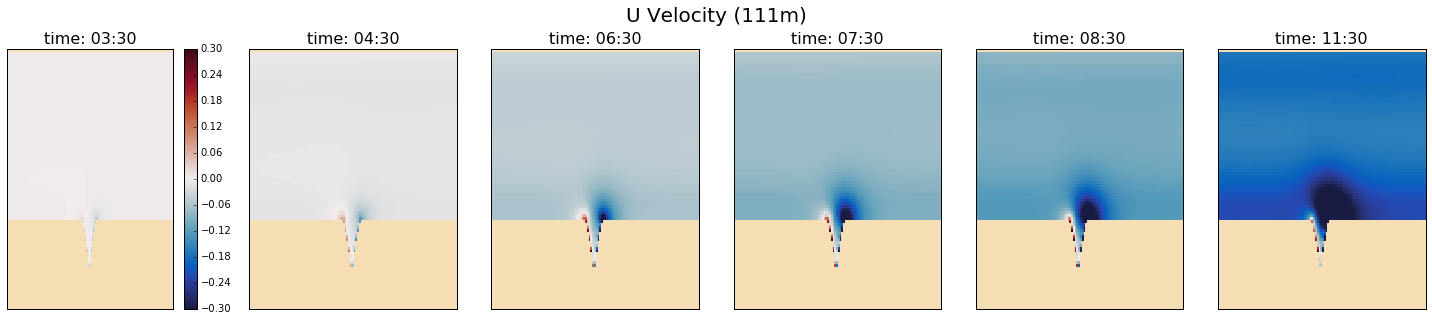

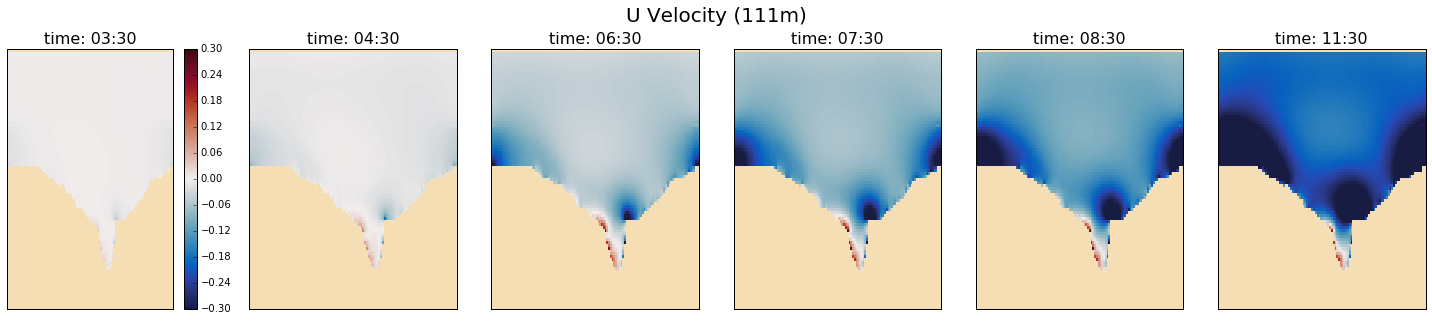

In [9]:
dep = 8
time_inds = [3,4,6,7,8,11]
bd = 0.3
max_min = True
supttl = 'U Velocity'
fig = plot_gyre_times(gridT_I2, U_I2, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)
fig = plot_gyre_times(gridT_R2, U_R2, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)

# Run03, 04, and 05: Lateral Boundary Conditions

These runs also use **ideal_bathy_01.nc**, **real_bathy_01.nc**, **coords_01.nc**, **temp_strat.nc**, and **salt_strat.nc**. For brevity, I only ran the idealized bathymetry to test the slip conditions.

### Notes
(Page 154 to 157) In namlbc:

| Parameter             | Description | Run01 (Id & Re)| Run02 (Id & Re)| Run03 (Id)| Run04 (Id)| Run05 (Id)|
|-----------------------|------------------------------------------------------------------------|---|---|-----|-----|
|rn_shlat|**free slip** = 0, 0 < **partial slip** < 2, **no slip** = 2, **strong slip** > 2| 0 | 0 | 0.25 | 0.5 | 2.0 |

The [Salish Sea Green Model Configurations](http://salishsea-meopar-docs.readthedocs.io/en/latest/results_server/nowcast-green.html) show an adjustment of rn_shlat to 0.5. The [Salish Sea Lateral Dynamics Notes](http://salishsea-meopar-docs.readthedocs.io/en/latest/turbulence/lateral_viscosity.html) show that the lateral eddy viscosity and choice of slip conditions go hand in hand. You want some slip to resolve the boundary layer, especially at lower viscosities.

In [10]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run03'
gridT_I3, lon_I3, lat_I3, tem_I3, sal_I3, ssh_I3, U_I3, V_I3, W_I3 = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run04'
gridT_I4, lon_I4, lat_I4, tem_I4, sal_I4, ssh_I4, U_I4, V_I4, W_I4 = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run05'
gridT_I5, lon_I5, lat_I5, tem_I5, sal_I5, ssh_I5, U_I5, V_I5, W_I5 = functions_plot.load_model_output(path, cfg)

In [42]:
U_I2[:,:,10:50, 45:70].shape

(12, 20, 40, 25)

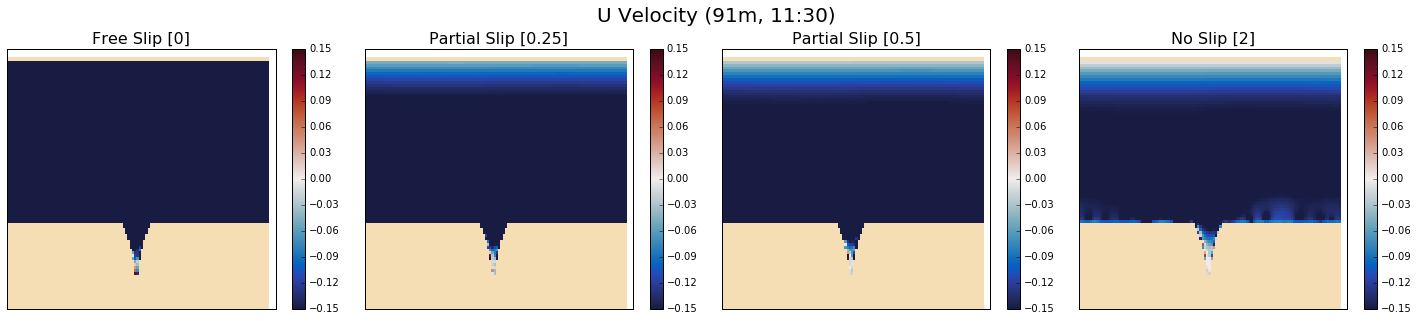

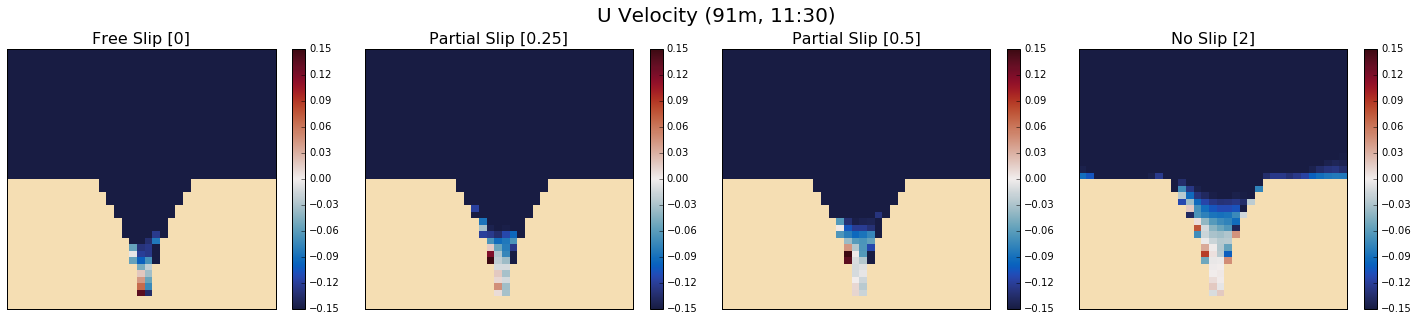

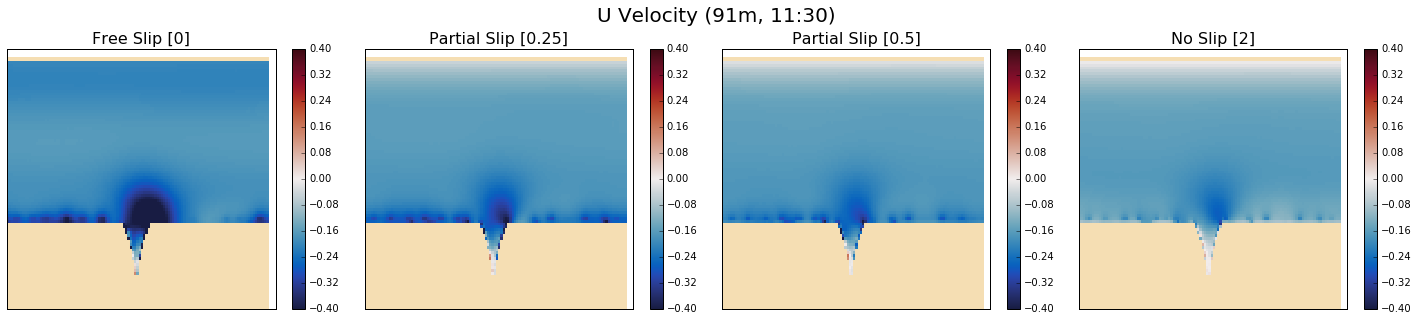

In [51]:
all_vars = [U_I2, U_I3, U_I4, U_I5]
depth_ind = 7
time_ind = 11
bd = [0.15]*4
max_min = True
supttl = 'U Velocity'
ttls = ['Free Slip [0]', 'Partial Slip [0.25]', 'Partial Slip [0.5]', 'No Slip [2]']
fig =  plot_vars(gridT_I2, all_vars, depth_ind, time_ind, bd, cmo.cm.balance, max_min, supttl, ttls)

all_vars_can = [U_I2[:,:,10:50, 40:75], U_I3[:,:,10:50, 40:75], U_I4[:,:,10:50, 40:75], U_I5[:,:,10:50, 40:75]]
fig =  plot_vars(gridT_I2, all_vars_can, depth_ind, time_ind, bd, cmo.cm.balance, max_min, supttl, ttls)

bd = [0.4]*4
fig =  plot_vars(gridT_I2, all_vars, depth_ind, time_ind, bd, cmo.cm.balance, max_min, supttl, ttls)

# Run 06: Diffusivity and Viscosity 

These runs also use **ideal_bathy_01.nc**, **real_bathy_01.nc**, **coords_01.nc**, **temp_strat.nc**, and **salt_strat.nc**.

### Notes
(Page 178) Laterial diffiusion is set through nameslist parameters in namdyn_ldf (lateral diffusion on momentum) and namtra_ldf (lateral diffusion scheme for tracers) and CPP keys:

| Parameter     |Namelist|Description                 | Run05 (Id)|
|---------------|------- |-----------------------------|-----------|
|ln_traldf_lap  |namtra|laplacian operator                        |true  |
|ln_traldf_bilap|namtra|bilaplacian operator                      |false |
|ln_dynldf_lap  |namdyn|laplacian operator                        |true  |
|ln_dynldf_bilap|namdyn|bilaplacian operator                      |false |
|rn_ahm_0_lap   |namdyn|horizontal laplacian eddy viscosity [m2/s]|100000|
|rn_aeiv_0      |namtra|eddy induced velocity coefficient [m2/s]  |0     |

[pg 179] When none of the key_dynldf...  and key_traldf... keys are defined, a constant value is used over the whole ocean for momentum and tracers, which is specified through the rn_ahm0 and rn_aht0 namelist parameters.

### Diffusivity
    ! Value rn_aeiv_0 is ignored unless = 0 with Held-Larichev spatially varying aeiv
    ! (key_traldf_c2d & key_traldf_eiv & key_orca_r2, _r1 or _r05)

[CONFIG/AMM12/EXP00](http://forge.ipsl.jussieu.fr/little_nemo/changeset/7/trunk/NEMOGCM/CONFIG/AMM12/EXP00) and [ORCA025.L75-GRD100, Dussin et al (2012)](https://www.drakkar-ocean.eu/publications/reports/orca025-grd100-report-dussin)

    rn_aeiv_0        =    0.     !     eddy induced velocity coefficient [m2/s]    (require "key_traldf_eiv") 
    (normally=0; not used with Griffies) 

[HadGEM3r1.1, Hewitt et al (2010)](http://geosci-model-dev.net/4/223/2011/gmd-4-223-2011.pdf) pg 246 has a list of cpp keys and the [Supplementary Material](http://www.geosci-model-dev.net/4/223/2011/gmd-4-223-2011-supplement.pdf) shows aeiv0 as 1000 and references the key:

    key_traldf_eiv = Eddy-induced (Gent-McWilliams) advection activated

The [Salish Sea Model](https://salishsea.eos.ubc.ca/_static/nemo/model_evaluation_summary.pdf) shows that the model uses a horizontal diffusivity and viscosity of 2m$^2$s$^{-1}$ for a resolution of 500 m. My resolution is 4000 m.

### Viscosity and Slip
[Salish Sea Docs](http://salishsea-meopar-docs.readthedocs.io/en/latest/turbulence/lateral_viscosity.html) 
* no slip shows stabilizing features
  * unresolved boundary layer, especially at low viscosities 

[Lab-Numerical Model Comparisons, Boyer et al (2003)](http://journals.ametsoc.org/doi/pdf/10.1175/1520-0485%282004%29034%3C1588%3ALMCOCF%3E2.0.CO%3B2) 
* no slip condition along the floor improves the model away from the canyon boundaries
  * but needs enhanced viscocities for stability
  * boundary layers too wide along the coastline
* vertical and horizontal viscosities were 1 and 100 times water for no slip
* pros of no slip: capturing symmetry across the canyon axis of lab experiments, predicting maximum of vorticity and horizontal divergence, and representing anticyclonic patter in upper left side of canyon
* cons of no slip: thick boundary layer of anticyclonic vorticity along canyon walls due to enhanced horizontal viscosity

In [59]:
! grep ln_traldf_bilap /ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/gyre_mackenzie02/EXP00/namelist_ref

   ln_traldf_bilap  =  .false.  !  bilaplacian operator
